In [2]:
import numpy  as np
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite as bi
import matplotlib.pyplot as plt
from datetime import datetime
from imp import reload 
import os
from tqdm import tqdm
from scipy import stats as st


import  weighted_network as wn
import dataset_construction as dc

import seaborn as sns
import bipcm

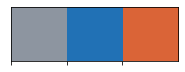

In [3]:
colours=['#8D95A0','#2171b5','#DA6437']
own=sns.color_palette(colours)

sns.palplot(own)
sns.set_palette(own)

# This notebook provides the codes for the figures and tables in the main paper

## Figures

### Figure 1: Cumulative frequency of treaties for different subjects in 2015

In [ ]:
df_subjects=pd.read_csv('IEA_data/subject_cat.csv')
df_treaty_subjects=pd.read_csv('IEA_data/subject_rel.csv')
df_parties_total=pd.read_csv("IEA_data/parties.csv",sep=",")

list_TypeofDates=['date_entry_into_force','date_ratification','date_simple_sigNMture','date_definite_sigNMture','date_withdrawal','date_consent_to_be_bound','date_accession_approv','date_acceptance_approv','date_provisioNMl_application','date_succession','date_reservation']
for i in list_TypeofDates:
    df_parties_total[i]=pd.to_datetime(df_parties_total[i],format='%d/%m/%Y')
df_parties_1=df_parties_total[(df_parties_total['date_entry_into_force']<datetime(1947,12,31))|(df_parties_total['date_ratification']<datetime(1947,12,31))]

old_treaties=set(df_parties_1['treaty_id'])
for i in old_treaties:
    df_parties_total=df_parties_total[df_parties_total['treaty_id']!=i]


df_notnull=df_parties_total[df_parties_total['date_ratification'].notnull()|df_parties_total['date_entry_into_force'].notnull()]
set_notnull=set(df_notnull['treaty_id'])

treaties=list(set(list(df_notnull['treaty_id'])))
df_treaties=pd.DataFrame(treaties,columns=['treaty_id'])
df_parties_1=pd.merge(df_treaties,df_treaty_subjects,left_on='treaty_id',right_on='treaty_id',how='left')

# get the distribution of the subjects
subject_distribution_notnull={}
for i in df_subjects['id']:
    key=list(df_subjects[df_subjects['id']==i]['subject'])[0]
    subject_distribution_notnull[key]=len(df_parties_1[df_parties_1['subject_id']==i])
    
subject_distribution_ordered_notnull=dict(sorted(subject_distribution_notnull.items(), key=lambda d: d[1]))

In [ ]:
sub_y=list(subject_distribution_ordered_notnull.keys())
sub_x=list(subject_distribution_ordered_notnull.values())
num_type=np.arange(len(sub_y))

x_lim=[0,180]


figsize = 12,9
figure, ax = plt.subplots(figsize=figsize)

font1 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 24,
    }

plt.barh(num_type, sub_x, color=colours[1],tick_label=sub_y,height=0.5)


ax.set_xlim(x_lim)

plt.xticks(np.arange(0, 176, step=25))

plt.tick_params(labelsize=23)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]

ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False) 
ax.spines['bottom'].set_visible(False) 

plt.tick_params(axis="both", which="both", bottom=False, top=False, labelbottom=True, left=False, right=False, labelleft=True) 


font2 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 32,
    }

plt.xlabel('Number of treaties',font2)
plt.ylabel("Subjects of treaties",font2)

plt.grid(axis='x',linestyle='--', linewidth=1.2,color="black", alpha=0.3)

plt.subplots_adjust(left=0.34) 


plt.savefig("results/TreatySubjectsOrdered_new.pdf", bbox_inches='tight')

### Figures 3-7： Cumulative frequency of nodes, Cumulative frequency of links, Average degree, Average strength, Cumulative density, Average weighted shortest distance, Global clustering coefficient from 1971 to 2015

In [ ]:
df_country=pd.read_csv('results/global_measures_country_network.csv')
df_UN=pd.read_csv('results/global_measures_country_network_UN.csv')
df_UNagency=pd.read_csv('results/gloabl_measures_country_without_UN&Agencies.csv')

In [ ]:
def plot_global_measures(x1,x2,x3,y1,y2,y3,x_lim,y_lim,x_label,y_label,loc,file_name):
   

    figsize = 12,9
    figure, ax = plt.subplots(figsize=figsize)

    
    A,=plt.plot(x1,y1,c=colours[1],label='All treaites',linewidth=4)
    C,=plt.plot(x2,y2,color=colours[0],label='Excluding UN treaties',linewidth=4, linestyle='--', alpha=0.9)
    D,=plt.plot(x3,y3,c=colours[0],label='Excluding UN & UN agency treaties',linewidth=4, linestyle=':',alpha=0.9)
    
    
    font1 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 22,
    }
    
    legend = plt.legend(handles=[A,C,D],prop=font1,loc=loc,facecolor=None )
    legend.get_frame().set_linewidth(0.0)

    ax.spines['top'].set_visible(False) 
    ax.spines['right'].set_visible(False) 
    ax.spines['left'].set_visible(False)
    
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left() 
    
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]
    
    
    plt.yticks(fontsize=25)    
    plt.xticks(fontsize=25)  
    

    plt.grid(axis='y',linestyle='--', linewidth=1.2,color="black", alpha=0.3)

        
    plt.tick_params(axis="both", which="both", bottom=False, top=False,    
                labelbottom=True, left=False, right=False, labelleft=True) 
    
    
    font2 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 32,
    }
    plt.xlabel(x_label,font2)
    plt.ylabel(y_label,font2)
    

    file_name='results/'+file_name+'.pdf'
    plt.savefig(file_name)



In [ ]:
aa='number_of_nodes'
bb='number_of_links'
cc='density'
dd='number_of_components'
ee='fraction_of_largest_component'
ff='average_degree'
gg='average_strength'
hh='average_weighted_shortest_path_length'
jj='weighted_global_clustering_coefficient'

In [ ]:
a='Cumulative frequency of nodes'
b='Cumulative frequency of links'
c='Cumulative density'
d='Cumulative frequency of components'
e='Fraction of the largest component'
f='Average degree'
g='Average strength'
h='Average weighted shortest distance'
j='Weighted global clustering coefficient'

In [ ]:
measure=cc
plot_global_measures(df_country['year'],df_UN['year'],df_UNagency['year'], df_country[measure],df_UN[measure],df_UNagency[measure],
         [1965,2020],[0.,1.01],'Year',c,'lower right','density')


### For figure 3(a)- Cumulative frequency of nodes. The proportion of countries is obtained by dividing the number of countries in the network by the actual number of countries in the world.

In [ ]:
dfc=pd.read_csv('IEA_data/countries_v1.csv') # date information of the foundation and extinction of countries

In [ ]:
# obtain the actual number of countries in the world till a specific year

dfc['foundation_time']=pd.to_datetime(dfc['foundation_time'],format='%d/%m/%Y')
dfc['ending_time']=pd.to_datetime(dfc['ending_time'],format='%d/%m/%Y')

dicc={}

for year in range(1971,2016):
    df1=dfc[(dfc['foundation_time']<=datetime(year,12,31))&(dfc['ending_time'].isnull())]
    df2=dfc[(dfc['foundation_time']<=datetime(year,12,31))&(dfc['ending_time']>datetime(year,12,31))]

    dicc[year]=len(df1)+len(df2)+len(dfc[dfc['foundation_time'].isnull()])

# obtain the proportion of countries 
df1=df_country.set_index('year')
df1['actual_num']=pd.Series(dicc)
df1.reset_index(inplace=True)

df1['ratio']=df1.apply(lambda x:round(x['number_of_nodes']/x['actual_num'],2), axis=1)

df2=df_UN.set_index('year')
df2['actual_num']=pd.Series(dicc)
df2.reset_index(inplace=True)
df2['ratio']=df2.apply(lambda x:round(x['number_of_nodes']/x['actual_num'],2), axis=1)


df3=df_UNagency.set_index('year')
df3['actual_num']=pd.Series(dicc)
df3.reset_index(inplace=True)
df3['ratio']=df3.apply(lambda x:round(x['number_of_nodes']/x['actual_num'],2), axis=1)


In [ ]:
measure='ratio'
plot_global_measures(df_country['year'],df_UN['year'],df_UNagency['year'], df_country[measure],df_UN[measure],df_UNagency[measure]
         [1965,2020],[0.,1],'Year','Proportion of countries','lower right','NodesRatio')


### For Figures 4(b) and 5(b): Degree distributi and Strength distributi

In [ ]:
df_local_sig=pd.read_csv('results/local_measures_country_network.csv')

In [ ]:
def distribution(df, year_list, minimum,maximum,num_intervals,xlim,ylim,x_label,y_label,file_name):
    
    figsize = 12,9
    figure, ax = plt.subplots(figsize=figsize)
  
    colours=['#8D95A0','#2171b5','#DA6437']
    colour_year=dict(zip(year_list,colours))
    
    width=1.5
    for year in year_list:
        y1=df[df['year']==year]['degree']
        dic_1=wn.frequency(list(y1),minimum,maximum,num_intervals)
        ax.bar(np.array(list(dic_1.keys())),dic_1.values(),width,color=colour_year[year], label=year)

    font1 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 24,
    }
    
    legend = plt.legend(prop=font1,loc='upper left',facecolor=None)
    legend.get_frame().set_linewidth(0.0)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.tick_params(labelsize=25)
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]
    
    ax.spines['top'].set_visible(False) 
    ax.spines['right'].set_visible(False) 
    ax.spines['left'].set_visible(False) 
    
    plt.tick_params(axis="both", which="both", bottom=False, top=False, labelbottom=True, left=False, right=False, labelleft=True) 
    
    internal=0.1
    for y in np.arange(ylim[0]+internal, ylim[1]+internal, internal):   
        plt.plot(range(xlim[0], xlim[1]), [y] * len(range(xlim[0], xlim[1])), "--", lw=1.2, color="black", alpha=0.3)  
      

    font2 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 32,
    }
    plt.xlabel(x_label,font2)
    plt.ylabel(y_label,font2)

    file_name='results/'+file_name+'.pdf'
    plt.savefig(file_name)


In [ ]:

distribution(df_local_sig, [1971,1990,2015], 0,200,100,[0,200],[0,0.8],'Degree','Fraction of nodes','DegreeDistribution_country')


## Figure 8: Centrality measures. Country rankings from 1980 to 2015.

In [ ]:
df_local_sig=pd.read_csv('results/local_measures_country_network.csv')

In [ ]:
# get the average values of evergy two years

def rank_cut(a):
    if a>50:
        return 55
    else:
        return(a)
    
measure='strength'
m_x=measure+'_x'
m_y=measure+'_y'
list_df=[]


for year in range(1980, 2016):
    df_1=df_local_sig[df_local_sig['year']==year][['country_name',measure]]
    df_2=df_local_sig[df_local_sig['year']==year+1][['country_name',measure]]

    df_3=df_1.merge(df_2, how='left', on='country_name')
    df_3[measure]=df_3.apply(lambda x: (x[m_x]+x[m_y])/2, axis=1)

    df_3['percentile']=df_3[measure].rank(method='min',ascending=False)
    df_3[year]=df_3.apply(lambda x: rank_cut(x['percentile']), axis=1)
    df_4=df_3[['country_name',year]].reset_index(drop=True)
    list_df.append(df_4)


df_ranking=list_df[0]

for i in range(1,len(list_df)):
    df_ranking=df_ranking.merge(list_df[i], how='outer', on='country_name')

df_plot_years=df_ranking.sort_values(by=2015)
df_plot_years.set_index('country_name', inplace=True)
df_plot=df_plot_years[list(range(1980,2016))]

In [ ]:
x_lim=[1977,2019]
y_lim=[56,0 ]
x_label='Year'
y_label='Ranking'


#figsize = 15,5
figsize = 15,6

figure, ax = plt.subplots(figsize=figsize)

countries=list(df_plot.sort_values(by=2015).index)
c_1=['France','United Kingdom','Germany','United States of America','South Africa','Russian Federation','Brazil','India', 'China', 'Japan','European Union']

    
rank=0
for c in c_1:
    
    plt.plot(list(range(1980,2016)),list(df_plot.loc[c]),label=c, linewidth=2., marker='o', mfc='w',markeredgewidth=2, ms=0,)
    
font1 = {'family' : 'Times New Roman', 'weight' : 'normal', 'size': 15}
    
legend = plt.legend(prop=font1, ncol=1, loc='lower right',facecolor=None )
legend.get_frame().set_linewidth(0.0)

plt.yticks([1]+list(np.arange(5, 55, 5)))
plt.gca().invert_yaxis()

ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
plt.tick_params(labelsize=25)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]

ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['bottom'].set_visible(False) 


plt.tick_params(axis="both", which="both", bottom=False, top=False, labelbottom=True, left=False, right=False, labelleft=True) 

internal=5
for y in np.arange(y_lim[1]+internal, y_lim[0]+internal, internal):   
    plt.plot(range(x_lim[0], x_lim[1]), [y] * len(range(x_lim[0], x_lim[1])), "--", lw=1.2, color="black", alpha=0.3)  

plt.plot(range(x_lim[0], x_lim[1]), [1] * len(range(x_lim[0], x_lim[1])), "--", lw=1.2, color="black", alpha=0.3)  



font2 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 25,
}


font3 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 25,
    }
    
plt.text(1974.6, 56, '>50', fontdict=font3)
plt.text(1975, -3, 'Ranking', fontdict=font3)


file_name='Strength'
file_output='results/'+file_name+'.pdf'

plt.savefig(file_output)

## Figure 9: Cooperation networks for different treaty subjects

In [ ]:
df_global_sea_fisheries=pd.read_csv('results/global_measures_treaty_network_sea&fisheries.csv')#
df_global_species=pd.read_csv('results/global_measures_treaty_network_species.csv')
df_global_waste=pd.read_csv('results/global_measures_treaty_network_waste.csv')
df_global_air=pd.read_csv('results/global_measures_treaty_network_air.csv')
df_global_resource=pd.read_csv('results/global_measures_treaty_network_water&resource.csv')


In [ ]:
def plot_four_one_axis(x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,internal,x_lim,y_lim, x_label,y_label,loc,file_name):
   
    
    figsize = 12,9
    figure, ax_1 = plt.subplots(figsize=figsize)
    
    ax_2 = ax_1.twiny()
    ax_3 = ax_1.twiny()
    ax_4 = ax_1.twiny()
    ax_5 = ax_1.twiny()
    ax_6 = ax_1.twiny()
    ax_7 = ax_1.twiny()
     
        
    font1 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 23,
    }
    
    
    A,=ax_1.plot(x1,y1, c=colours[1], label='Sea & Fisheries',linewidth=4)
    B,=ax_2.plot(x2,y2, c='#5996AC', label='Wild species & ecosystems',linewidth=4)
    C,=ax_3.plot(x3,y3, c=colours[2], label='Waste & hazardous substances',linewidth=4)
    
    D,=ax_4.plot(x4,y4, c='#E4B345', label='Natural resources',linewidth=4)
    E,=ax_5.plot(x5,y5, c=colours[0], label='Air & atmosphere',linewidth=4)
    
    
    ax_1.spines['top'].set_visible(False) 
    ax_1.spines['right'].set_visible(False) 
    ax_1.spines['left'].set_visible(False) 
    
    ax_2.spines['top'].set_visible(False) 
    ax_2.spines['right'].set_visible(False) 
    ax_2.spines['left'].set_visible(False) 
    
    ax_3.spines['top'].set_visible(False) 
    ax_3.spines['right'].set_visible(False) 
    ax_3.spines['left'].set_visible(False) 
    
    ax_4.spines['top'].set_visible(False)
    ax_4.spines['right'].set_visible(False) 
    ax_4.spines['left'].set_visible(False)
    
    ax_5.spines['top'].set_visible(False)
    ax_5.spines['right'].set_visible(False) 
    ax_5.spines['left'].set_visible(False) 
    
    ax_6.spines['top'].set_visible(False) 
    ax_6.spines['right'].set_visible(False)
    ax_6.spines['left'].set_visible(False) 
    
    ax_7.spines['top'].set_visible(False) 
    ax_7.spines['right'].set_visible(False) 
    ax_7.spines['left'].set_visible(False) 

  
    legend = plt.legend(handles=[A,B,C,D,E],prop=font1,loc=loc,facecolor=None,ncol=2)
    legend.get_frame().set_linewidth(0.0)
    
   
    for y in np.arange(y_lim[0]+internal, y_lim[1]+internal, internal):   
        ax_1.plot(range(x_lim[0], x_lim[1]), [y] * len(range(x_lim[0], x_lim[1])), "--", lw=1.2, color="black", alpha=0.3)  
        

    ax_1.tick_params(axis="both", which="both", bottom=False, top=False,    
               labelbottom=True, left=False, right=False, labelleft=True,labeltop=False)
    
    ax_2.tick_params(axis="both", which="both", bottom=False, top=False,    
               labelbottom=False, left=False, right=False, labelleft=True, labeltop=False)
    
    ax_3.tick_params(axis="both", which="both", bottom=False, top=False,    
               labelbottom=False, left=False, right=False, labelleft=True,labeltop=False)
    
    ax_4.tick_params(axis="both", which="both", bottom=False, top=False,    
               labelbottom=False, left=False, right=False, labelleft=True,labeltop=False)
    
    ax_5.tick_params(axis="both", which="both", bottom=False, top=False,    
               labelbottom=False, left=False, right=False, labelleft=True,labeltop=False)
    
    ax_6.tick_params(axis="both", which="both", bottom=False, top=False,    
               labelbottom=False, left=False, right=False, labelleft=True,labeltop=False)
    ax_7.tick_params(axis="both", which="both", bottom=False, top=False,    
               labelbottom=False, left=False, right=False, labelleft=True,labeltop=False)
    
    
    ax_1.set_xlim(x_lim)
    ax_1.set_ylim(y_lim)
    
    ax_2.set_xlim(x_lim) 
    ax_3.set_xlim(x_lim)
    ax_4.set_xlim(x_lim)
    ax_5.set_xlim(x_lim)
    ax_6.set_xlim(x_lim)
    ax_7.set_xlim(x_lim)
    
    labels_1 = ax_1.get_xticklabels() + ax_1.get_yticklabels()
    [(label.set_fontsize(25), label.set_fontname('Times New Roman')) for label in labels_1]
    
   
    font2 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 32,
    }
    ax_1.set_xlabel(x_label,font2)
    ax_1.set_ylabel(y_label,font2)
   
    
    file_name='significant_networks_subjects/1980/'+file_name+'.pdf'
    plt.savefig(file_name)


In [ ]:
aa='number_of_nodes'
bb='number_of_links'
cc='density'
dd='number_of_components'
ee='fraction_of_largest_component'
ff='average_degree'
gg='average_strength'
hh='average_weighted_shortest_path_length'
jj='weighted_global_clustering_coefficient'

a='Cumulative frequency of nodes'
b='Cumulative frequency of links'
c='Cumulative density'
d='Cumulative frequency of components'
e='Fraction of the largest component'
f='Average degree'
g='Average strength'
h='Average weighted shortest distance'
j='Weighted global clustering coefficient'

In [ ]:
x1=df_global_sea_fisheries['year']
x2=df_global_species['year']
x3=df_global_waste['year']

x4=df_global_resource['year']
x5=df_global_air['year']

measure=hh
y1=np.array(df_global_sea_fisheries[measure])
y2=np.array(df_global_species[measure])
y3=np.array(df_global_waste[measure])
y4=np.array(df_global_resource[measure])
y5=np.array(df_global_air[measure])


In [ ]:
plot_four_one_axis(x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,10,[1978,2020],[0,70],'Year',h,'best','PathLength_subjects')

## Figure 10: Country networks for different treaty categories in 2015

In [ ]:
G_dic=dc.significant_network_bipcm_Gs([2015],None, [6,13], 'bottom', True, 0,None, True)

##### 1. Networks for different subjects can be obtained by selecting different sets of subject ids.
##### Subjects: [6,13]--sea and fisheries; [14]--Waste and hazardous substances; [16]--Wild species and ecosystems; [4]--energy; [2]--air;  [1,3,5,7,8,9,11,12,15]--natural resources 


In [ ]:
def country_maps(G,file_name):
    
    import cartopy
    import cartopy.io.shapereader as shpreader
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import matplotlib.patches as mp

    # define the positons of countries
    df_geo=pd.read_csv("IEA_data/geograpical information of countries.csv",sep=',',encoding='latin-1')
    # a dict of positions
    pos={v['Id']:(v['longitude'],v['latitude']) for k, v in df_geo.to_dict('index').items()} 
    
    # change the projection, so the  ccrs.Robinson() can be uesed
    geodetic = ccrs.Geodetic()
    robinson = ccrs.Robinson()
    pos_proj={k:robinson.transform_point(v[0],v[1], geodetic) for k, v in pos.items()}
    

    # define the sizes of nodes
    degree = nx.degree(G)
    # a list of sizes
    degrees = [degree[iata] for iata in G.nodes]
    sizes =degrees
    #sizes = [ i/max(degrees)*100 for i in degrees]


    # define the colors of nodes
    dic_bet=wn.local_clustering_coefficient(G)
    #dic_bet=wn.betweenness_centrality_weighted(G)
    colors = [dic_bet[iata]*100 for iata in G.nodes]

    # define the labels of nodes
    # labels = {iata: iata if deg[iata] >= 20 else for iata in sg.nodes}
    labels = {iata: iata for iata in G.nodes}



    res = ['110m', '50m', '10m']
    east = -172#  East longitude is +; west longitude is -
    west = 180
    north = 90 # North latitude is +; south latitude is -
    south = -60


    projection =ccrs.Robinson()

    def create_axes():
        plt.figure(figsize=(15, 12))
        ax = plt.axes(
            projection=projection)
        ax.set_extent([west, east, south, north]) 

        #ax.set_global()
        ax.outline_patch.set_edgecolor('white')
        return ax


    ax = create_axes()
    countries = cfeature.NaturalEarthFeature(category='cultural', name='admin_0_countries', scale='110m',facecolor='none')
    ax.coastlines(color='white',linewidth=2, resolution=res[0])
    ax.add_feature(countries, edgecolor='white',facecolor='lightgrey', alpha=0.8, linewidth=0.5) 


    nodes = nx.draw_networkx_nodes(G, ax=ax,
                     alpha=.8,
                     node_size=sizes,
                     node_shape="o",
                     label=labels,
                     pos=pos_proj,
                     node_color=colors,
                     cmap=plt.cm.autumn_r, # plt.cm.RdBu_r---choose color maps
                     #edgecolors = "#fdae6b",
                     linewidths = 0
                    )


    
    A = np.triu(nx.to_numpy_matrix(G),1)
    G_directed=nx.from_numpy_matrix(A, create_using=nx.DiGraph)
    
    
    edges = G.edges()
    edge_weights = [G[u][v]['weight'] for u,v in edges]
    edge_weights.sort(reverse=True)
    w=edge_weights[int(len(edge_weights)*1-1)]
    #edge_weights = [u / max(edge_weights)  for u in edge_weights]
    edge_list = [(u,v) for u,v,e in G.edges(data=True) if e['weight'] >=w]
    portion=len(edge_list)/len(edge_weights)


    edges=nx.draw_networkx_edges(G_directed, ax=ax,
                     alpha=1,
                     edgelist=edge_list,
                     #width=,
                     #edge_color='#969696', 
                     edge_color='#2171b5',
                     arrows = True,
                     connectionstyle=('Arc3,rad=0.2'),
                     arrowsize=0.01,
                     pos=pos_proj
                    )

    # the numbers represent the order
    ax.set_zorder(1)
    nodes.set_zorder(3)
    for i in range(len(edge_list)):
        edges[i].set_zorder(2)
    
    font = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 15,
            }
    
    file_output = 'results/'+file_name+'.pdf'
    plt.savefig(file_output, bbox_inches='tight', pad_inches=.2, dpi=1000)
    
    return portion

In [ ]:
country_maps(G_dic[2015],'CountryMap_Sea')